In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from collections import Counter
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

In [4]:
data_dir = r'D:\12th Semester\CVPR\animal_dataset'
class_names = ['cat', 'dog', 'panda']
class_to_idx = {'cat': 0, 'dog': 1, 'panda': 2}

X = []
y = []

print("Loading images...")
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('L')      # Grayscale
        img = img.resize((32, 32))
        img_array = np.array(img).flatten()          # 1024 features
        X.append(img_array)
        y.append(class_to_idx[class_name])

X = np.array(X)   # Shape: (300, 1024)
y = np.array(y)   # Shape: (300,)

print(f"Loaded {len(X)} images")
print(f"Class distribution: Cat={np.sum(y==0)}, Dog={np.sum(y==1)}, Horse={np.sum(y==2)}")

Loading images...
Loaded 300 images
Class distribution: Cat=100, Dog=100, Horse=100


In [5]:
def create_stratified_folds(X, y, n_folds=5, seed=42):
    np.random.seed(seed)
    folds = [[] for _ in range(n_folds)]
    indices_by_class = {0: [], 1: [], 2: []}
    
    for idx, label in enumerate(y):
        indices_by_class[label].append(idx)
    
    for label in indices_by_class:
        np.random.shuffle(indices_by_class[label])
        for i, idx in enumerate(indices_by_class[label]):
            folds[i % n_folds].append(idx)
    
    # Shuffle within folds
    for fold in folds:
        np.random.shuffle(fold)
    
    return folds

folds = create_stratified_folds(X, y, n_folds=5)
print("Stratified 5-fold indices created.")

Stratified 5-fold indices created.


In [6]:
def knn_predict(X_train, y_train, X_test, k, distance_type='l1'):
    predictions = []
    
    for test_img in X_test:
        if distance_type == 'l1':
            distances = np.sum(np.abs(X_train - test_img), axis=1)  # Manhattan
        elif distance_type == 'l2':
            distances = np.sqrt(np.sum((X_train - test_img)**2, axis=1))  # Euclidean
        
        # Get indices of k smallest distances
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]
        
        # Majority vote
        most_common = Counter(nearest_labels).most_common(1)[0][0]
        predictions.append(most_common)
    
    return np.array(predictions)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

In [7]:
k_values = range(1, 31)
l1_scores = []
l2_scores = []

print("Running 5-fold cross-validation (from scratch)...")

for k in k_values:
    fold_acc_l1 = []
    fold_acc_l2 = []
    
    for val_fold_idx in range(5):
        val_indices = folds[val_fold_idx]
        train_indices = []
        for i in range(5):
            if i != val_fold_idx:
                train_indices.extend(folds[i])
        
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_val = X[val_indices]
        y_val = y[val_indices]
        
        # L1
        pred_l1 = knn_predict(X_train, y_train, X_val, k=k, distance_type='l1')
        fold_acc_l1.append(accuracy(y_val, pred_l1))
        
        # L2
        pred_l2 = knn_predict(X_train, y_train, X_val, k=k, distance_type='l2')
        fold_acc_l2.append(accuracy(y_val, pred_l2))
    
    l1_scores.append(np.mean(fold_acc_l1))
    l2_scores.append(np.mean(fold_acc_l2))
    print(f"K={k:2d} | L1: {l1_scores[-1]:.2f}% | L2: {l2_scores[-1]:.2f}%")

# Convert to numpy
l1_scores = np.array(l1_scores)
l2_scores = np.array(l2_scores)

Running 5-fold cross-validation (from scratch)...
K= 1 | L1: 31.67% | L2: 36.00%
K= 2 | L1: 31.67% | L2: 36.00%
K= 3 | L1: 32.00% | L2: 39.67%
K= 4 | L1: 33.67% | L2: 39.00%
K= 5 | L1: 36.00% | L2: 38.33%
K= 6 | L1: 33.67% | L2: 41.00%
K= 7 | L1: 30.67% | L2: 42.67%
K= 8 | L1: 30.67% | L2: 44.33%
K= 9 | L1: 31.67% | L2: 41.67%
K=10 | L1: 32.67% | L2: 44.67%
K=11 | L1: 30.00% | L2: 46.67%
K=12 | L1: 34.33% | L2: 47.67%
K=13 | L1: 34.00% | L2: 48.67%
K=14 | L1: 33.33% | L2: 49.00%
K=15 | L1: 32.67% | L2: 46.67%
K=16 | L1: 35.33% | L2: 46.00%
K=17 | L1: 34.33% | L2: 47.00%
K=18 | L1: 35.67% | L2: 47.00%
K=19 | L1: 34.33% | L2: 44.67%
K=20 | L1: 32.33% | L2: 48.00%
K=21 | L1: 31.67% | L2: 45.00%
K=22 | L1: 33.00% | L2: 44.67%
K=23 | L1: 34.33% | L2: 44.67%
K=24 | L1: 33.67% | L2: 44.00%
K=25 | L1: 34.33% | L2: 45.67%
K=26 | L1: 32.00% | L2: 44.00%
K=27 | L1: 33.33% | L2: 46.33%
K=28 | L1: 31.00% | L2: 47.33%
K=29 | L1: 32.33% | L2: 46.00%
K=30 | L1: 32.00% | L2: 45.00%


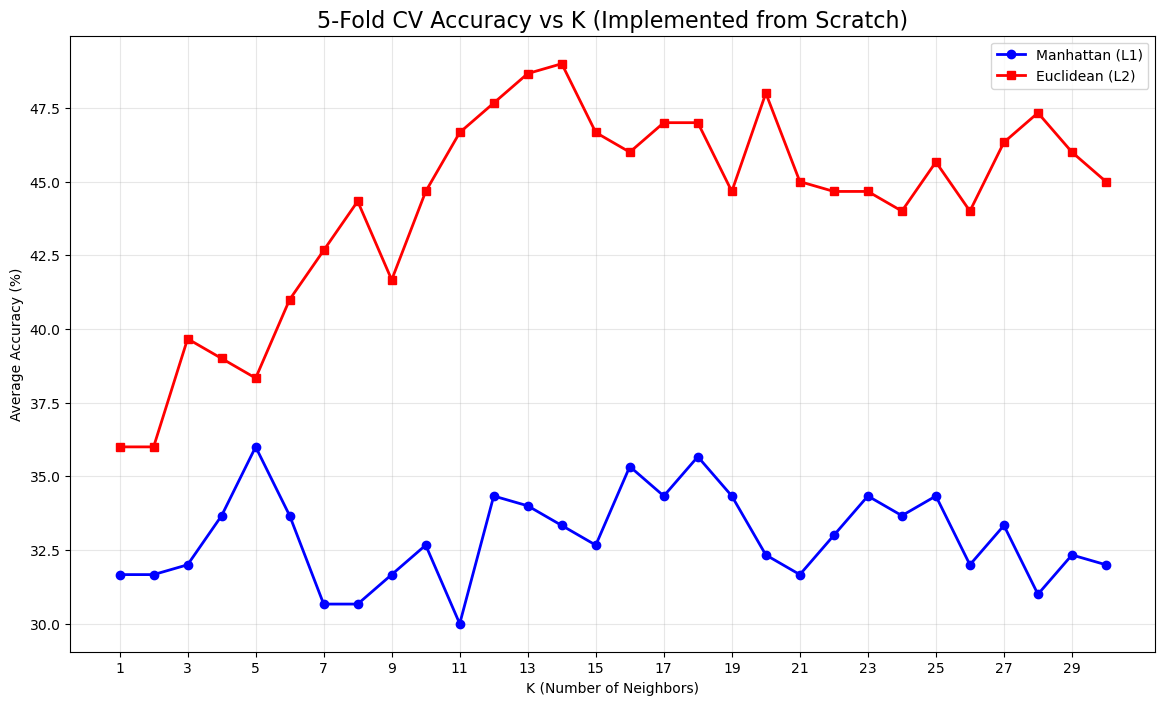


Best L1 (Manhattan):  K=5, Accuracy=36.00%
Best L2 (Euclidean):  K=14, Accuracy=49.00%

WINNER: Euclidean (L2) with K=14 → 49.00%


In [8]:
plt.figure()
plt.plot(k_values, l1_scores, 'o-', label='Manhattan (L1)', color='blue', linewidth=2)
plt.plot(k_values, l2_scores, 's-', label='Euclidean (L2)', color='red', linewidth=2)
plt.title('5-Fold CV Accuracy vs K (Implemented from Scratch)', fontsize=16)
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Average Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 31, 2))
plt.show()

# Find best
best_k_l1 = np.argmax(l1_scores) + 1
best_acc_l1 = l1_scores.max()

best_k_l2 = np.argmax(l2_scores) + 1
best_acc_l2 = l2_scores.max()

print(f"\nBest L1 (Manhattan):  K={best_k_l1}, Accuracy={best_acc_l1:.2f}%")
print(f"Best L2 (Euclidean):  K={best_k_l2}, Accuracy={best_acc_l2:.2f}%")

if best_acc_l1 > best_acc_l2:
    best_k = best_k_l1
    best_metric = 'l1'
    winner = "Manhattan (L1)"
else:
    best_k = best_k_l2
    best_metric = 'l2'
    winner = "Euclidean (L2)"

print(f"\nWINNER: {winner} with K={best_k} → {max(best_acc_l1, best_acc_l2):.2f}%")

In [9]:
print(f"Training final KNN model with K={best_k}, Distance={best_metric.upper()} on all 300 images...")

# We'll store full training data
X_full = X
y_full = y

print("Final model ready!")

Training final KNN model with K=14, Distance=L2 on all 300 images...
Final model ready!


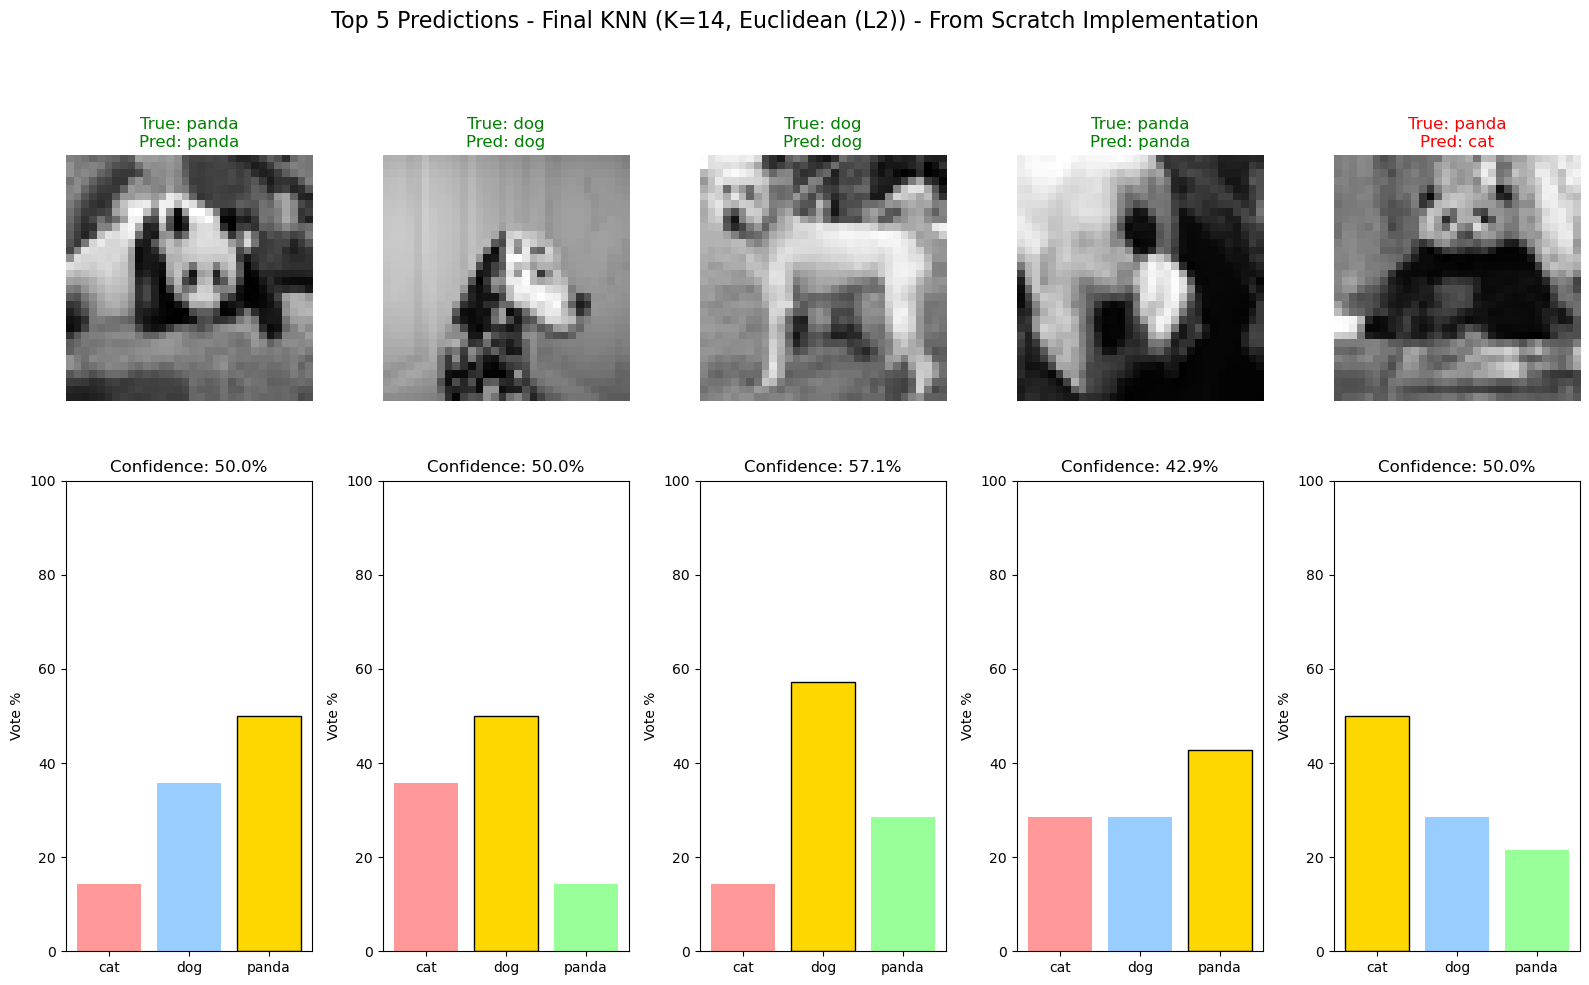

In [10]:
def knn_predict_with_proba(X_train, y_train, test_img, k, distance_type='l1'):
    if distance_type == 'l1':
        distances = np.sum(np.abs(X_train - test_img), axis=1)
    else:
        distances = np.sqrt(np.sum((X_train - test_img)**2, axis=1))
    
    nearest_idx = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest_idx]
    
    # Count votes
    vote_counts = Counter(nearest_labels)
    pred_label = vote_counts.most_common(1)[0][0]
    
    # Confidence = proportion of neighbors voting for winner
    confidence = vote_counts[pred_label] / k
    
    # Per-class probability
    probs = np.zeros(3)
    for label in range(3):
        probs[label] = vote_counts.get(label, 0) / k
    
    return pred_label, confidence, probs

# Pick 5 random images
np.random.seed(123)
indices = np.random.choice(len(X), 5, replace=False)

plt.figure(figsize=(16, 10))
for i, idx in enumerate(indices):
    img_flat = X[idx]
    true_label = y[idx]
    pred_label, conf, probs = knn_predict_with_proba(X_full, y_full, img_flat, k=best_k, distance_type=best_metric)
    pred_name = class_names[pred_label]
    true_name = class_names[true_label]
    
    # Display image
    plt.subplot(2, 5, i+1)
    plt.imshow(img_flat.reshape(32, 32), cmap='gray')
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=12)
    plt.axis('off')
    
    # Confidence bar
    plt.subplot(2, 5, i+6)
    bars = plt.bar(class_names, probs*100, color=['#ff9999','#99ccff','#99ff99'])
    bars[pred_label].set_color('gold')
    bars[pred_label].set_edgecolor('black')
    plt.ylim(0, 100)
    plt.title(f"Confidence: {conf*100:.1f}%")
    plt.ylabel("Vote %")

plt.suptitle(f"Top 5 Predictions - Final KNN (K={best_k}, {winner}) - From Scratch Implementation", fontsize=16)
plt.tight_layout()
plt.show()